In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

In [2]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

import random 
from types import SimpleNamespace

import torch

from torch.utils.data import DataLoader

from models.autoencoder import VariationalAutoEncoder, AutoEncoder
from models.mlp import MLP
from utils.data_utils import TorchDataset

from utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
thefts = pd.read_csv("../dataset/final/valid_train_thefts.csv")
non_thefts = pd.read_csv("../dataset/final/valid_train_non_theft_suc_theft_acct.csv")
non_thefts2 = pd.read_csv("../dataset/final/non_thefts_k_100000.csv")
non_thefts3 = pd.read_csv("../dataset/final/non_thefts_k_200000.csv")
non_thefts4 = pd.read_csv("../dataset/final/non_thefts_k_300000.csv")
non_thefts5 = pd.read_csv("../dataset/final/non_thefts_k_400000.csv")
non_thefts6 = pd.read_csv("../dataset/final/non_thefts_k_500000.csv")
non_thefts7 = pd.read_csv("../dataset/final/non_thefts_k_600000.csv")
non_thefts8 = pd.read_csv("../dataset/final/non_thefts_k_700000.csv")
non_thefts9 = pd.read_csv("../dataset/final/non_thefts_k_709000.csv")

non_thefts8['target'] = 0

non_thefts = pd.concat([non_thefts, non_thefts2, non_thefts3,
                       non_thefts4, non_thefts5, non_thefts6,
                       non_thefts7, non_thefts8, non_thefts9])
#thefts.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
#non_thefts.drop(columns=['acct', 'successor', 'voltage'], inplace=True)
print(len(non_thefts))
non_thefts.drop_duplicates(inplace=True)
print(len(non_thefts))

711808
711808


In [5]:
non_thefts.head()

,acct,successor,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,...,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,voltage,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,100915,2,4,0,11.444444,9.086538,10.463880,10.860656,1.002664,122,...,78.333333,104.0,106,LOW,0,1,12.0,0,0,0
1,102718,2,6,0,7.290323,5.607143,6.254461,6.030303,0.568356,132,...,121.600000,121.0,213,LOW,3,1,35.0,0,0,0
2,103875,2,3,0,4.264463,1.000000,2.632231,2.632231,1.632231,121,...,63.500000,63.5,142,LOW,2,2,25.0,0,0,0
3,10539,2,3,0,17.456140,12.758929,15.107534,15.107534,2.348606,112,...,84.500000,84.5,1543,LOW,2,2,25.0,0,2,0
4,10607,1,10,0,20.971014,2.967480,6.842664,3.920000,6.070888,250,...,129.777778,121.0,618,LOW,0,1,12.0,0,1,0


In [6]:
df = pd.concat([thefts, non_thefts])
df.fillna(-1, inplace=True)

In [7]:
clusters = pd.read_csv("../dataset/final/geo_clusters.csv")

In [8]:
df.head()

,acct,successor,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,...,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,voltage,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
0,100040,1,12,2,18.950000,0.000000,6.735356,7.049180,4.964937,350,...,144.181818,122.0,152,LOW,0,1,12.0,0,0,1
1,100915,1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,...,122.416667,121.0,341,LOW,0,1,12.0,0,1,1
2,101153,1,5,5,0.000000,0.000000,0.000000,0.000000,0.000000,125,...,122.250000,122.0,1251,LOW,2,1,25.0,0,3,1
3,101214,1,6,1,9.434066,4.546448,5.873035,4.989218,1.803735,371,...,197.200000,182.0,190,LOW,2,6,25.0,0,0,1
4,102718,1,8,0,19.565574,1.910569,10.585130,10.008197,5.580233,246,...,139.142857,121.0,821,LOW,3,1,35.0,0,5,1


In [9]:
clusters.head()

,ACCT_NBR,cluster,mini_cluster
0,102718,0,2
1,10346,0,4
2,103875,0,4
3,11049,0,1
4,110978,0,0


In [10]:
clusters = clusters.rename(columns={'ACCT_NBR': 'acct'})
clusters.head()

,acct,cluster,mini_cluster
0,102718,0,2
1,10346,0,4
2,103875,0,4
3,11049,0,1
4,110978,0,0


In [11]:
df = pd.merge(df, clusters, on='acct')

In [12]:
df.head()

,acct,successor,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,...,days_since_last_measurement,voltage,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target,cluster,mini_cluster
0,100040,1,12,2,18.950000,0.000000,6.735356,7.049180,4.964937,350,...,152,LOW,0,1,12.0,0,0,1,7,0
1,100915,1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,...,341,LOW,0,1,12.0,0,1,1,7,3
2,100915,1,13,2,12.071429,0.000000,7.221644,10.070525,4.807979,243,...,341,LOW,0,1,12.0,0,1,1,7,3
3,100915,2,4,0,11.444444,9.086538,10.463880,10.860656,1.002664,122,...,106,LOW,0,1,12.0,0,0,0,7,3
4,100915,2,4,0,11.444444,9.086538,10.463880,10.860656,1.002664,122,...,106,LOW,0,1,12.0,0,0,0,7,3


In [13]:
df = df.loc[(df.cluster == 0) & (df.mini_cluster == 0)]

In [14]:
df.head()

,acct,successor,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,...,days_since_last_measurement,voltage,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target,cluster,mini_cluster
128,110978,8,7,0,1.983607,0.120968,1.010454,0.824633,0.722805,155,...,386,LOW,1,2,15.0,0,3,1,0,0
129,110978,8,7,0,1.983607,0.120968,1.010454,0.824633,0.722805,155,...,386,LOW,1,2,15.0,0,3,1,0,0
130,110978,6,3,2,0.386139,0.000000,0.193069,0.193069,0.193069,124,...,1520,LOW,1,2,15.0,0,3,0,0,0
131,110978,6,3,2,0.386139,0.000000,0.193069,0.193069,0.193069,124,...,1520,LOW,1,2,15.0,0,3,0,0,0
132,110978,7,6,1,5.616000,0.000000,2.518927,2.297521,1.928909,125,...,1045,LOW,1,2,15.0,0,6,0,0,0


In [15]:
len(df)

22362

In [16]:
df = df.drop(columns=['acct', 'successor', 'voltage', 'cluster', 'mini_cluster'])
df = df.drop_duplicates()

In [17]:
len(df)

22148

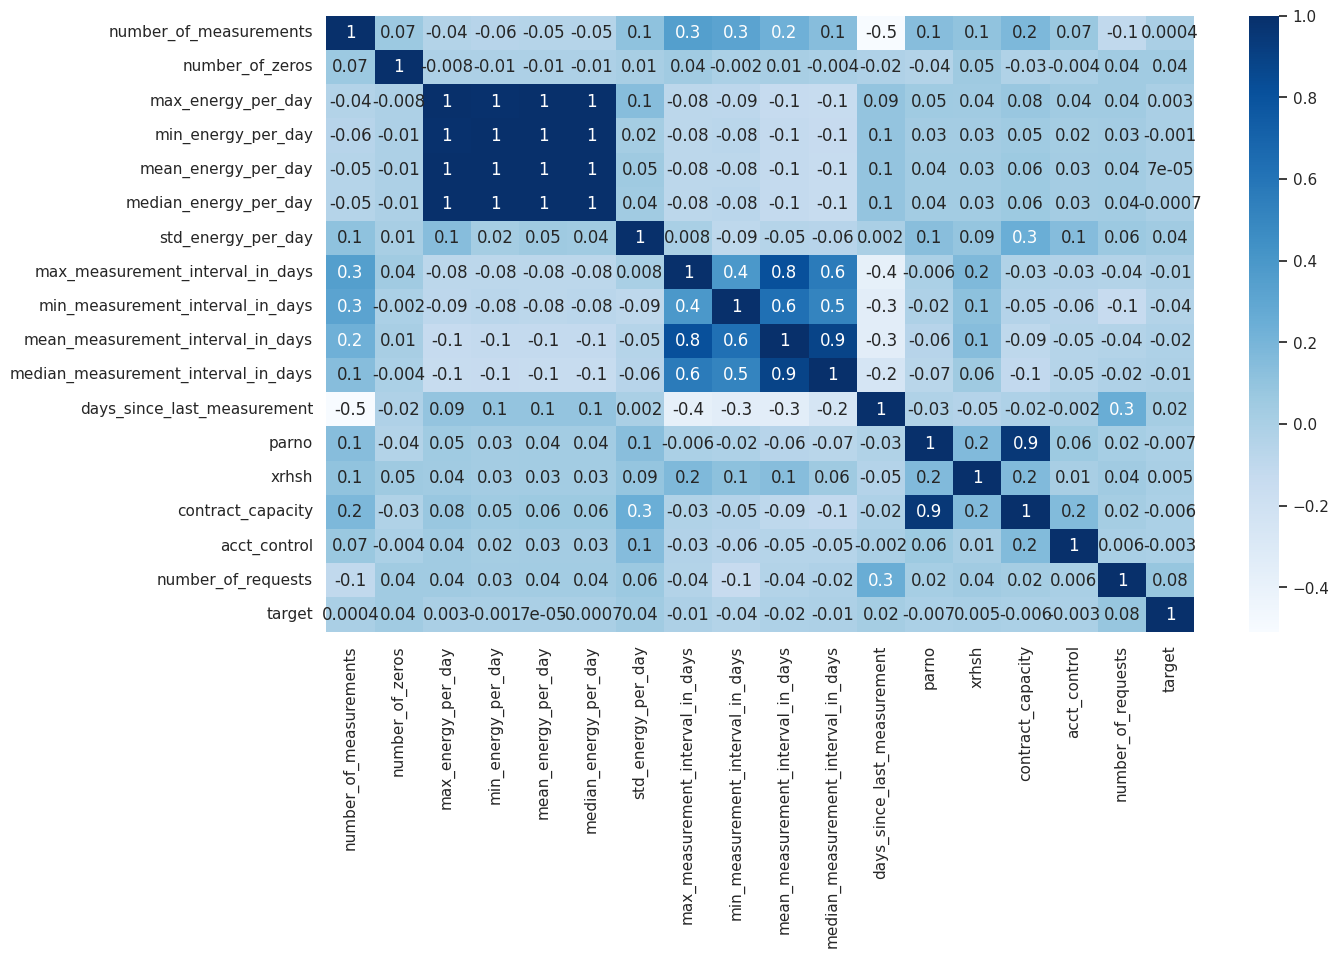

In [18]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [19]:
scaler = MinMaxScaler()

In [20]:
#df.drop(['xrhsh', 'parno', 'acct_control', 'contract_capacity', 'min_measurement_interval_in_days', 'max_energy_per_day'], axis=1, inplace=True)
print("Bincount of y:", df['target'].value_counts())

Bincount of y: 0    22103
1       45
Name: target, dtype: int64


In [21]:
df.head()

,number_of_measurements,number_of_zeros,max_energy_per_day,min_energy_per_day,mean_energy_per_day,median_energy_per_day,std_energy_per_day,max_measurement_interval_in_days,min_measurement_interval_in_days,mean_measurement_interval_in_days,median_measurement_interval_in_days,days_since_last_measurement,parno,xrhsh,contract_capacity,acct_control,number_of_requests,target
128,7,0,1.983607,0.120968,1.010454,0.824633,0.722805,155,16,109.833333,121.5,386,1,2,15.0,0,3,1
130,3,2,0.386139,0.000000,0.193069,0.193069,0.193069,124,101,112.500000,112.5,1520,1,2,15.0,0,3,0
132,6,1,5.616000,0.000000,2.518927,2.297521,1.928909,125,19,95.000000,119.0,1045,1,2,15.0,0,6,0
134,3,0,14.796117,7.958678,11.377397,11.377397,3.418719,121,103,112.000000,112.0,162,1,2,15.0,0,0,0
243,13,0,8.504132,3.650000,4.681490,4.232874,1.285682,248,119,132.166667,121.5,166,2,2,25.0,0,8,1


In [22]:
train = df[df['target'] == 0]
train, val = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

test_target1 = df[(df['target'] == 1)]

In [23]:
train.target.value_counts(), val.target.value_counts(), test_target1.target.value_counts()

(0    17682
 Name: target, dtype: int64,
 0    4421
 Name: target, dtype: int64,
 1    45
 Name: target, dtype: int64)

In [24]:
X_train = train.drop('target', axis=1)
y_train = train['target']
X_val = val.drop('target', axis=1)
y_val = val['target']
X_test_1 = test_target1.drop('target', axis=1)
y_test_1 = test_target1['target']

In [25]:
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test_1 = scaler.transform(X_test_1)

In [102]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.svm import OneClassSVM

X_val = np.concatenate([X_val, X_test_1])
y_test = pd.concat([y_val, y_test_1])

#model = IsolationForest(contamination='auto')
model = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True)

model.fit(X_train)
#scores = model.score_samples(X_test)
y_pred = model.predict(X_test)
scores = 

y_pred_test = np.where(scores >= 0, 0, 1)
probs = expit(-scores)

print(len(y_test), len(y_pred_test))

acc, precision, recall, f1 = get_classification_metrics(
    y_test, y_pred_test)
print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}"
              )

brier, roc_auc, pr_auc = get_probability_measures(y_test,
                                                  probs)
lift, demotion, weighted_score = get_lift_demotion_scores(
   y_test.values, probs, num_samples=int(0.1 * len(y_test_1)))

print(f"brier: {brier:.4f}, roc-auc: {roc_auc:.4f}, pr-auc: {pr_auc:.4f}"
              )
print(f"lift: {lift:.4f}, demotion: {demotion:.4f}, weighted: {weighted_score:.4f}"
              )


AttributeError: 'numpy.ndarray' object has no attribute 'negative_outlier_factor_'

In [26]:
train_dataset = TorchDataset(
    X=torch.tensor(X_train).float(),
    y=torch.tensor(y_train.to_numpy()).float()
)  # reconstruction
val_dataset = TorchDataset(
    X=torch.tensor(X_val).float(),
    y=torch.tensor(y_val.to_numpy()).float()
)

test_dataset_one = TorchDataset(
    X=torch.tensor(X_test_1).float(),
    y=torch.tensor(y_test_1.to_numpy()).float()
)

X_test = np.concatenate([X_val, X_test_1], axis=0)
y_test = pd.concat([y_val, y_test_1])
test_dataset = TorchDataset(
    X=torch.tensor(X_test).float(),
    y=torch.tensor(y_test.to_numpy()).float()
)

In [27]:
np.bincount(y_train), np.bincount(y_val), np.bincount(y_test)

(array([17682]), array([4421]), array([4421,   45]))

In [28]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=False
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)
test_zero = DataLoader(
    test_dataset_one, batch_size=1, shuffle=False
)

In [29]:
encoder = MLP(
    in_size=X_train.shape[1],
    layer_units=[16, 8],
    out_size=4,
    vae=False)
decoder = MLP(
    in_size=4, 
    layer_units=[8, 16],
    out_size=X_train.shape[1]
)
model = AutoEncoder(encoder, decoder)
model

AutoEncoder(
  (encoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=17, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features=8, out_features=4, bias=True)
    )
  )
  (decoder): MLP(
    (MLP): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=17, bias=True)
    )
  )
)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.MSELoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    
args = dict(model=model, train_loader=train_loader, 
            test_loader=val_loader,
            epochs=100, optimizer=optimizer, 
            criterion=criterion,
            reconstruction=True, vae=False,
            device=device, verbose=True, return_best=True)

Epoch: 1/100
[Train]	Loss=0.031086527847703445
[Test]	Loss=0.005559338854706223

Epoch: 2/100
[Train]	Loss=0.003565687314644254
[Test]	Loss=0.0025369918715918986

Epoch: 3/100
[Train]	Loss=0.00191076056758922
[Test]	Loss=0.001372143729646831

Epoch: 4/100
[Train]	Loss=0.0013241146951235973
[Test]	Loss=0.0012385464793074502

Epoch: 5/100
[Train]	Loss=0.0012234094554590396
[Test]	Loss=0.0011550835492893411

Epoch: 6/100
[Train]	Loss=0.0011403656931055935
[Test]	Loss=0.0010704515050014602

Epoch: 7/100
[Train]	Loss=0.001053519120480306
[Test]	Loss=0.0009786004025535992

Epoch: 8/100
[Train]	Loss=0.0009797513867041288
[Test]	Loss=0.0009095129195145137

Epoch: 9/100
[Train]	Loss=0.0009302253923635714
[Test]	Loss=0.000874924159184996

Epoch: 10/100
[Train]	Loss=0.0009003716758742868
[Test]	Loss=0.0008519153184384751

Epoch: 11/100
[Train]	Loss=0.0008774305282562304
[Test]	Loss=0.0008304413389615553

Epoch: 12/100
[Train]	Loss=0.0008593280786003372
[Test]	Loss=0.0008184448516468699

Epoch: 13

Epoch: 99/100
[Train]	Loss=0.0004734786083510442
[Test]	Loss=0.0004512435787402616

Epoch: 100/100
[Train]	Loss=0.00047269682457294165
[Test]	Loss=0.00045065618775074753

Best loss (0.0005) found on epoch 100


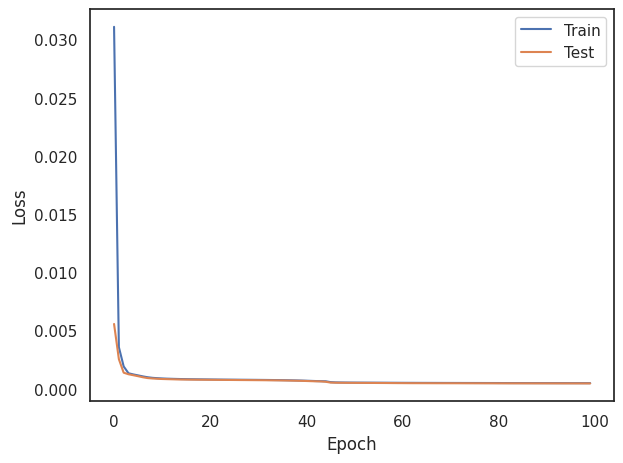

In [31]:
args = SimpleNamespace(**args)
model = model.fit(args)

In [32]:
tmp_train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=False
)
tmp_val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

In [33]:
def make_preds(model, data_loader):
    loss_dist = []
    model.eval()
    for x, _ in data_loader:
        x = x.to(device)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
    return loss_dist  

In [34]:
def plot_loss_dist(loss_dist):
    loss = []
    for i in loss_dist:
        loss.append((i,i))
    plt.scatter(*zip(*loss))
    plt.show()
    plt.close()
    
    plt.hist(loss_dist, bins=50)
    plt.show()
    plt.close()

In [35]:
train_loss_dist = make_preds(model, tmp_train_loader)

In [36]:
len(train_loss_dist)

17682

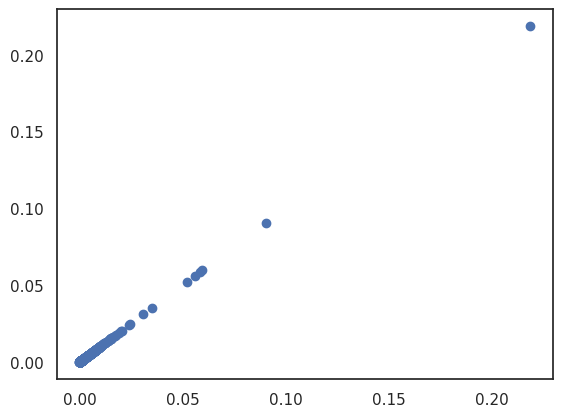

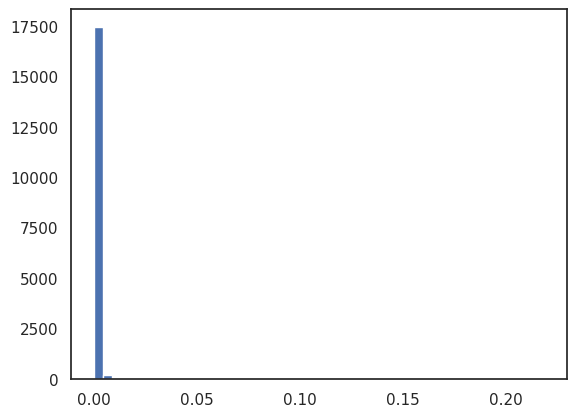

In [37]:
plot_loss_dist(train_loss_dist)

4421


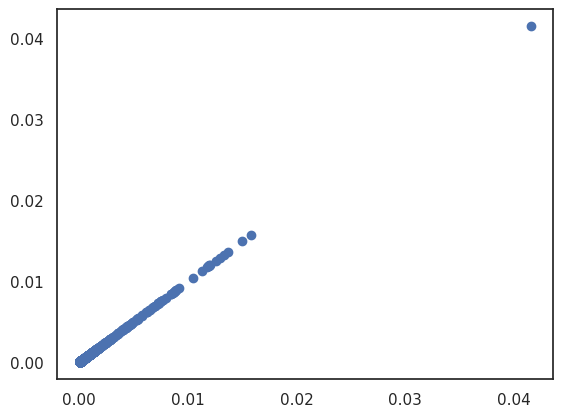

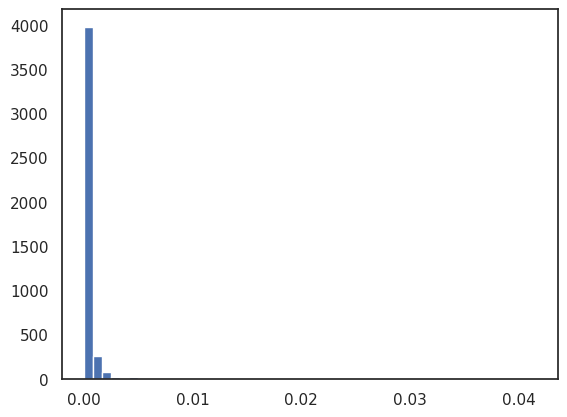

In [38]:
val_loss_dist = make_preds(model, tmp_val_loader)
print(len(val_loss_dist))
plot_loss_dist(val_loss_dist)

In [39]:
sorted_train = sorted(train_loss_dist, reverse=True)
print("Train", sorted_train[:10])
print("\n\n")

sorted_val = sorted(val_loss_dist, reverse=True)
print("Val", sorted_val[:10])
print("\n\n")

print(f"Train Mean: {statistics.mean(train_loss_dist)}, Median: {statistics.median(train_loss_dist)}")
print(f"Val Mean: {statistics.mean(val_loss_dist)}, Median: {statistics.mean(val_loss_dist)}")

Train [0.21872352063655853, 0.09040862321853638, 0.05966707691550255, 0.058657120913267136, 0.056063517928123474, 0.05193311348557472, 0.03529577702283859, 0.030953506007790565, 0.024586444720625877, 0.024028142914175987]



Val [0.041548483073711395, 0.015767674893140793, 0.01501064095646143, 0.013659083284437656, 0.013280510902404785, 0.012913297861814499, 0.012555057182908058, 0.012003726325929165, 0.011965197511017323, 0.011941210366785526]



Train Mean: 0.00046955180623947765, Median: 0.00016927596152527258
Val Mean: 0.00045180831906338703, Median: 0.00045180831906338703


In [40]:
np.mean(train_loss_dist) + 2*np.std(train_loss_dist), np.mean(train_loss_dist) + np.std(train_loss_dist)

(0.004961564971876341, 0.002715558389057909)

45


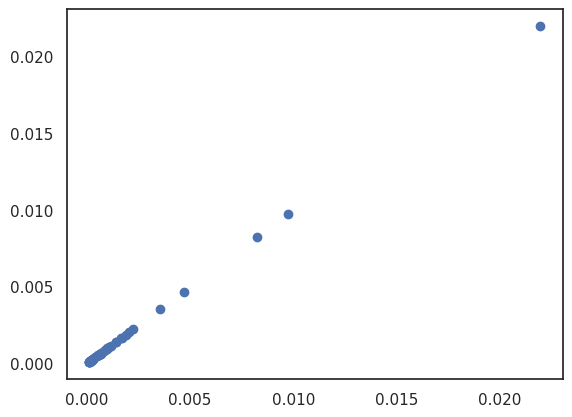

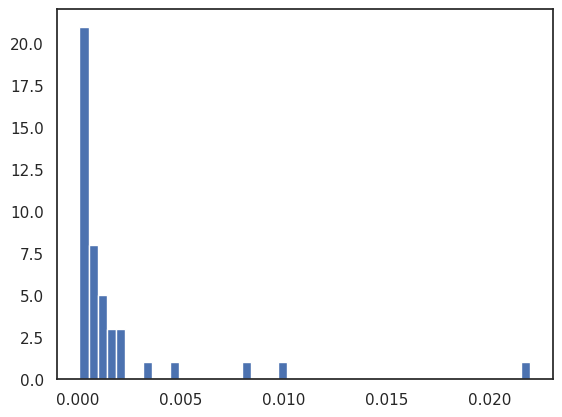

In [41]:
test_zero_loss_dist = make_preds(model, test_zero)
print(len(test_zero_loss_dist))
plot_loss_dist(test_zero_loss_dist)

In [42]:
sorted_test = sorted(test_zero_loss_dist, reverse=True)
print("Test zero", sorted_test[:10])
print("\n\n")

print(f"Test Mean: {statistics.mean(test_zero_loss_dist)}, Median: {statistics.median(test_zero_loss_dist)}")

Test zero [0.02195204794406891, 0.009745631366968155, 0.00824106577783823, 0.004683856386691332, 0.0035500077065080404, 0.002218433655798435, 0.002049923874437809, 0.0018885170575231314, 0.0016908873803913593, 0.0016707879258319736]



Test Mean: 0.001672332604357507, Median: 0.0005642583128064871


In [43]:
np.percentile(train_loss_dist, 20), np.percentile(val_loss_dist, 20), np.percentile(test_zero_loss_dist, 20)

(9.747771691763774e-05, 9.854300878942013e-05, 0.00018129963136743755)

In [44]:
zero_below, zero_above = [], [] 
for i in test_zero_loss_dist:
    if i < 0.00015:
        zero_below.append(i)
    else:
        zero_above.append(i)
len(zero_below), len(zero_above)

(6, 39)

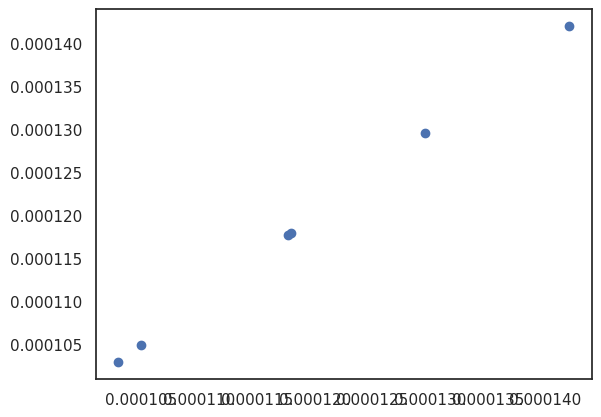

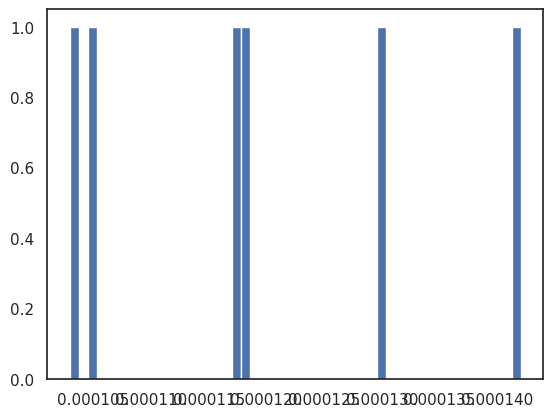

In [45]:
plot_loss_dist(zero_below)

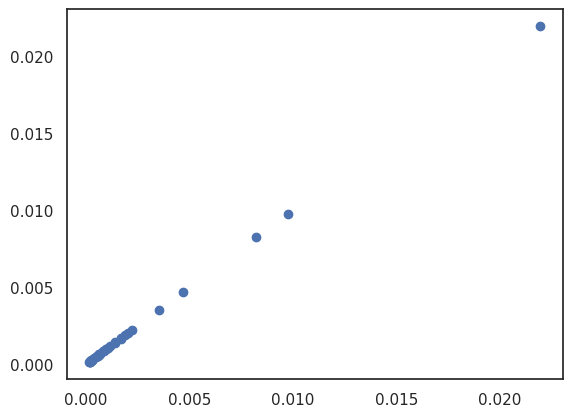

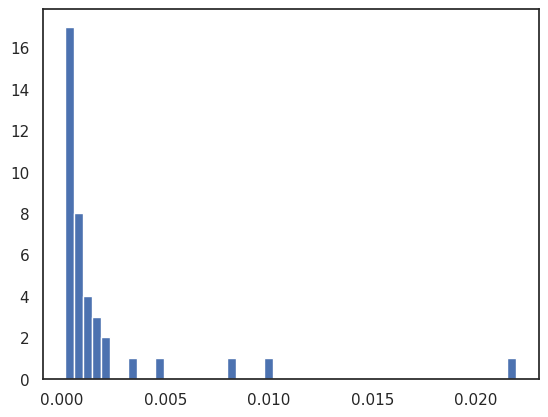

In [46]:
plot_loss_dist(zero_above)

In [47]:
test_loss_dist = make_preds(model, test_loader)
len(test_loss_dist)

4466

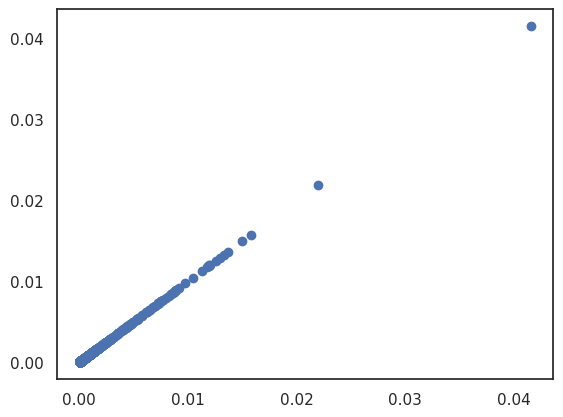

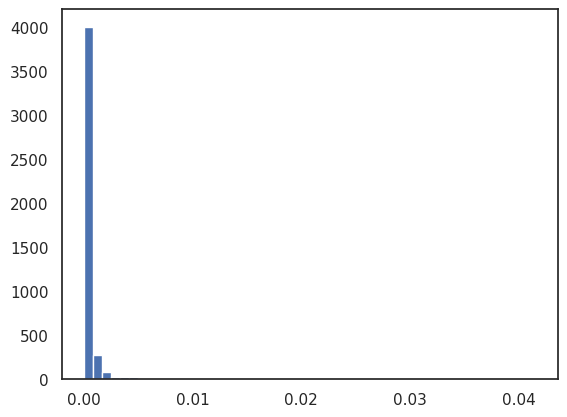

In [48]:
plot_loss_dist(test_loss_dist)

In [49]:
#total_losses = train_loss_dist[:]
#total_losses.extend(test_loss_dist)
total_losses = test_loss_dist
total_losses = np.array(total_losses)

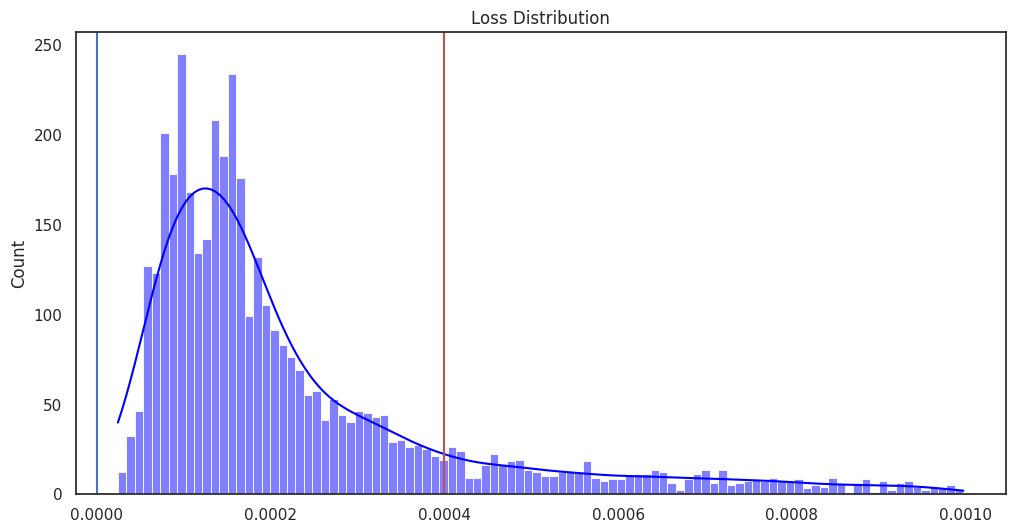

In [50]:
lower_threshold = 0.0
upper_threshold = 0.0004
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot( total_losses[total_losses < 0.001],bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [51]:
def make_preds_and_classify(model, data_loader, threshold=1e-4):
    loss_dist = []
    y_true, y_pred = [], []
    y_scores = []
    model.eval()
    for x, y in data_loader:
        x = x.to(device)
        y_true.append(y)
        sample = model(x)
        loss = torch.nn.MSELoss()(x, sample)
        loss_dist.append(loss.item())
        if loss.item() < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
        # np.exp(-losses) / np.sum(np.exp(-losses))

    losses = np.array(loss_dist)
    probs = np.exp(-losses) / np.sum(np.exp(-losses))
    
    m = np.median(losses)
    ad = np.abs(losses - m)
    mad = np.median(ad)
    probs2 =1/(1 + np.exp(-0.6745 * ad / mad))
    
    scaler = MinMaxScaler()
    scaler.fit(probs2.reshape(-1, 1))
    probs3 = scaler.transform(probs2.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    scaler.fit(probs.reshape(-1, 1))
    probs4 = scaler.transform(probs2.reshape(-1, 1))
    
    probs5 = 1/(1 + np.exp(-losses))
    print(probs5.min(), probs5.max())
    
    scaler = MinMaxScaler()
    scaler.fit(probs5.reshape(-1, 1))
    probs6 = scaler.transform(probs5.reshape(-1, 1))
    
    scaler = MinMaxScaler()
    scaler.fit(losses.reshape(-1, 1))
    probs7 = scaler.transform(losses.reshape(-1,1))
    
    
    y_true = torch.cat(y_true, dim=0)
    num_ones = torch.sum(y_true == 1).item()
    print("Num ones", num_ones)
    
    acc, precision, recall, f1 = get_classification_metrics(y_true.numpy(), np.array(y_pred))
    
    print("Probs2:", get_probability_measures(y_true.numpy(), probs2))

    print("Probs2",get_lift_demotion_scores(y_true.numpy(), probs2,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    
    print("Probs3:", get_probability_measures(y_true.numpy(), probs3))

    print("Probs3",get_lift_demotion_scores(y_true.numpy(), probs3,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    print("Probs4:", get_probability_measures(y_true.numpy(), probs4))

    print("Probs4",get_lift_demotion_scores(y_true.numpy(), probs4,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    
    print("Probs5:", get_probability_measures(y_true.numpy(), probs5))

    print("Probs5",get_lift_demotion_scores(y_true.numpy(), probs5,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    
    print("Probs6:", get_probability_measures(y_true.numpy(), probs6))

    print("Probs6",get_lift_demotion_scores(y_true.numpy(), probs6,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    print("Probs7:", get_probability_measures(y_true.numpy(), probs7))

    print("Probs7",get_lift_demotion_scores(y_true.numpy(), probs7,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False))
    
    brier, roc_auc, pr_auc = get_probability_measures(y_true.numpy(), probs)

    lift, demotion, weighted = get_lift_demotion_scores(y_true.numpy(), probs,
                                                            num_samples=int(1 * num_ones),
                                                            verbose=False)
    
    return acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, losses
  

In [52]:
acc, precision, recall, f1, brier, roc_auc, pr_auc, lift, demotion, weighted, loss_dist = make_preds_and_classify(model, test_loader, 
                        threshold=0.0002)
print(f"[Test] Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}\n"
                f"\t\tBrier score loss: {brier}, ROC-AUC: {roc_auc}, PR-AUC: {pr_auc}\n"
                f"\t\tLift: {lift}, Demotion: {demotion}, Weighted Score: {weighted}\n")

0.5000060354068406 0.5103856267728388
Num ones 45
Probs2: (0.5193235647527916, 0.7081555203699514, 0.03194614401933363)
Probs2 (0.06666666666666667, 1.0, 0.3466666666666667)
Probs3: (0.2722724249349857, 0.7081555203699514, 0.03194614401933363)
Probs3 (0.06666666666666667, 1.0, 0.3466666666666667)
Probs4: (None, 0.7081555203699514, 0.03194614401933363)
Probs4 (0.06666666666666667, 1.0, 0.3466666666666667)
Probs5: (0.2501077165005555, 0.7539319912538642, 0.045356489237292505)
Probs5 (0.06666666666666667, 1.0, 0.3466666666666667)
Probs6: (0.010337355486970023, 0.7539319912538642, 0.045356489237292505)
Probs6 (0.06666666666666667, 1.0, 0.3466666666666667)
Probs7: (None, 0.7539319912538642, 0.045356489237292505)
Probs7 (0.06666666666666667, 1.0, 0.3466666666666667)
[Test] Accuracy: 0.5772503358710255, Precision: 0.018295870360690015, Recall: 0.7777777777777778, F1: 0.035750766087844735
		Brier score loss: 0.010071673952688582, ROC-AUC: 0.24606800874613588, PR-AUC: 0.006182312823314553
		Lif

In [53]:
np.percentile(loss_dist, 45)

0.00015960783639457077

In [54]:
print(f"Test Mean: {statistics.mean(loss_dist)}, Median: {statistics.median(loss_dist)}")

Test Mean: 0.00046410648136482803, Median: 0.00017129842308349907


In [55]:
train_loss_dist = np.array(train_loss_dist)
test_zero_loss_dist = np.array(test_zero_loss_dist)

In [56]:
len(test_zero_loss_dist)

45

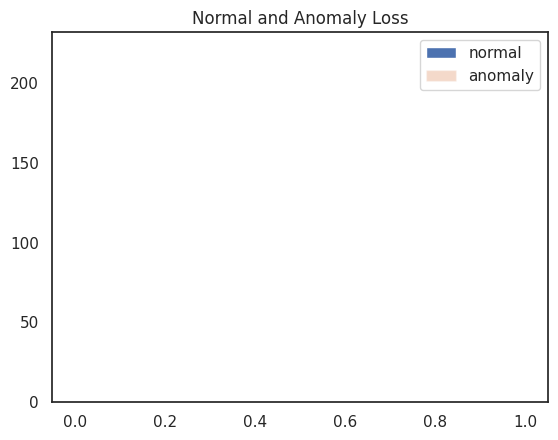

In [82]:
plt.hist(train_loss_dist[train_loss_dist < 0.0001][:3000], bins=50, label='normal', )
plt.hist(test_zero_loss_dist[test_zero_loss_dist < 0.0001], bins=50, label='anomaly', alpha=0.3)
#plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [58]:
tmp_train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=False
)
tmp_val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

In [59]:
train_data = []

In [60]:
for x, y in tmp_train_loader:
        x = x.to(device)
        encoded = model.encode(x)
        train_data.append(encoded.cpu().numpy()[0])

In [61]:
tmp_train_np = np.vstack(train_data)

In [62]:
len(tmp_train_np)

17682

In [63]:
my_dataframe = pd.DataFrame(tmp_train_np, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])

In [64]:
my_dataframe['target'] = 0
my_dataframe.head()

,feature_1,feature_2,feature_3,feature_4,target
0,1.775795,-2.861407,1.398544,1.288579,0
1,2.865079,-2.894641,0.567984,1.177642,0
2,1.043836,-2.994994,0.599186,1.656138,0
3,3.805982,-2.632568,-0.874444,-0.488098,0
4,1.101412,-2.991813,0.513319,1.552315,0


In [65]:
my_dataframe.to_csv('train_encoded.csv', index=False)

In [66]:
val_data = []
for x, y in tmp_val_loader:
        x = x.to(device)
        encoded = model.encode(x)
        val_data.append(encoded.cpu().numpy()[0])
tmp_val_np = np.vstack(val_data)
my_dataframe = pd.DataFrame(tmp_val_np, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
my_dataframe['target'] = 0
my_dataframe.head()

,feature_1,feature_2,feature_3,feature_4,target
0,1.816898,-3.618089,-0.042425,1.178032,0
1,2.408502,-2.339040,1.019554,1.654503,0
2,2.832719,-2.790671,-1.615084,-0.346490,0
3,2.102283,-2.474225,1.165875,1.312416,0
4,2.568359,-3.417711,0.814422,0.832117,0


In [67]:
my_dataframe.to_csv('val_encoded.csv', index=False)

In [68]:
len(test_zero)

45

In [69]:
test_data = []
for x, y in test_zero:
        x = x.to(device)
        encoded = model.encode(x)
        test_data.append(encoded.cpu().numpy()[0])
tmp_test_np = np.vstack(test_data)
my_dataframe = pd.DataFrame(tmp_test_np, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4'])
my_dataframe['target'] = 1
my_dataframe.head()

,feature_1,feature_2,feature_3,feature_4,target
0,1.808252,-2.706451,0.305479,1.299515,1
1,0.744496,-2.484582,0.643721,1.517639,1
2,2.405409,-2.958885,1.100158,1.583598,1
3,2.019685,-3.005156,-0.093896,1.922730,1
4,1.559217,-3.269520,0.149431,1.348723,1


In [70]:
my_dataframe.to_csv('test_encoded.csv', index=False)

In [71]:
train_data = []
model.eval()
for x, y in tmp_train_loader:
        x = x.to(device)
        encoded = model(x)
        train_data.append(encoded.detach().cpu().numpy()[0])
tmp_train_np = np.vstack(train_data)
my_dataframe = pd.DataFrame(tmp_train_np, columns=[f'feature_{i}' for i in range(len(tmp_train_np[0]))])
my_dataframe['target'] = 0
my_dataframe.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,target
0,0.188069,0.006029,0.000892,0.000860,0.000873,0.000872,0.001161,0.190700,0.167392,0.179548,0.165091,0.027954,0.010090,0.016455,0.004459,0.000216,0.010610,0
1,0.067646,0.003316,0.000672,0.000636,0.000652,0.000651,0.000726,0.068900,0.045185,0.084810,0.092276,0.177124,0.009422,0.005664,0.003860,0.000235,0.012115,0
2,0.210494,0.006475,0.002380,0.002253,0.002307,0.002304,0.004462,0.186607,0.156631,0.168214,0.153564,0.022743,0.329177,0.037735,0.099713,0.001460,0.011012,0
3,0.029117,0.004446,0.001509,0.001440,0.001473,0.001470,0.000897,0.056151,0.060582,0.080983,0.088829,0.872567,0.009562,0.025441,0.003778,0.000109,0.030928,0
4,0.182779,0.006846,0.002547,0.002413,0.002470,0.002467,0.004605,0.190278,0.159640,0.179437,0.165401,0.031113,0.329536,0.029112,0.101355,0.001295,0.012867,0


In [72]:
my_dataframe.to_csv('train_decoded.csv', index=False)

In [73]:
val_data = []
model.eval()
for x, y in tmp_val_loader:
        x = x.to(device)
        encoded = model(x)
        val_data.append(encoded.detach().cpu().numpy()[0])
tmp_val_np = np.vstack(val_data)
my_dataframe = pd.DataFrame(tmp_val_np, columns=[f'feature_{i}' for i in range(len(tmp_val_np[0]))])
my_dataframe['target'] = 0
my_dataframe.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,target
0,0.158886,0.003063,0.001110,0.001039,0.001070,0.001068,0.001801,0.202595,0.051862,0.151617,0.143236,0.204888,0.317574,0.004670,0.102649,0.000135,0.015816,0
1,0.040001,0.005992,0.001284,0.001222,0.001249,0.001248,0.001514,0.050371,0.077442,0.085127,0.093750,0.044773,0.009105,0.010997,0.003560,0.002382,0.010784,0
2,0.045638,0.006402,0.004921,0.004653,0.004777,0.004770,0.004153,0.085319,0.090768,0.120878,0.131747,0.864938,0.330927,0.046359,0.098913,0.000399,0.044668,0
3,0.094441,0.007689,0.001372,0.001320,0.001343,0.001341,0.001576,0.103211,0.131180,0.147769,0.156586,0.053117,0.008430,0.013085,0.003814,0.000644,0.014716,0
4,0.142176,0.002857,0.000411,0.000392,0.000400,0.000400,0.000455,0.193358,0.056297,0.152021,0.144685,0.211077,0.007930,0.003084,0.003786,0.000023,0.013749,0


In [74]:
my_dataframe.to_csv('val_decoded.csv', index=False)

In [75]:
test_data = []
model.eval()
for x, y in test_zero:
        x = x.to(device)
        encoded = model(x)
        test_data.append(encoded.detach().cpu().numpy()[0])
tmp_test_np = np.vstack(test_data)
my_dataframe = pd.DataFrame(tmp_test_np, columns=[f'feature_{i}' for i in range(len(tmp_test_np[0]))])
my_dataframe['target'] = 1
my_dataframe.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,target
0,0.091918,0.007352,0.002632,0.002497,0.002556,0.002552,0.003611,0.109035,0.098463,0.145069,0.154333,0.117303,0.126604,0.014514,0.040296,0.001259,0.019787,1
1,0.182797,0.013122,0.005879,0.005617,0.005729,0.005723,0.009841,0.185488,0.198289,0.185585,0.170032,0.026485,0.338707,0.150790,0.107642,0.005466,0.016354,1
2,0.096303,0.003402,0.000548,0.000521,0.000533,0.000532,0.000713,0.088087,0.073001,0.117074,0.129427,0.043036,0.009752,0.004430,0.003852,0.000220,0.008764,1
3,0.061464,0.003395,0.001704,0.001577,0.001633,0.001630,0.003012,0.054564,0.041165,0.073931,0.082823,0.077810,0.357776,0.007517,0.099547,0.003124,0.010394,1
4,0.136719,0.004725,0.001796,0.001690,0.001736,0.001733,0.002971,0.178034,0.078738,0.167920,0.165497,0.117826,0.324379,0.007505,0.104328,0.000422,0.017039,1


In [76]:
my_dataframe.to_csv('test_decoded.csv', index=False)